In [1]:
import math
import time
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from copy import deepcopy
import torch.nn
import torchvision.transforms as transforms
import torchvision
from NetworkWrapper import *
from Dataloader import *
import numpy as np
import math
import cv2
from torchsummary import summary
import shutil
import os
import datetime

# Setting Up The Dataloader

In [2]:
train_set = OpenCVDataset(mode="train",
                          transform=None,
                          pre_transform=torch.Tensor,
                          data_dir="processed",
                          filter_success=True,
                          col_ranges=[[" x_0"," y_67"]])

val_set = OpenCVDataset(mode="test",
                        transform=None,
                        pre_transform=torch.Tensor,
                        data_dir="processed",
                        filter_success=True,
                        col_ranges=[[" x_0"," y_67"]])

(21523, 136)
Pre-Transforming Data
Finished Pre-Transforming.
(5357, 136)
Pre-Transforming Data
Finished Pre-Transforming.


# Creating out network
Creating a network structure using nn.Sequential.
When we call the forward method, it goes through these one by one.

In [3]:
class Squeeze(nn.Module):
    def __init__(self):
        super(Squeeze, self).__init__()

        self.squeeze = torch.squeeze

    def forward(self, data):
        return self.squeeze(data)

## It seems that dropout layers do not improve accuracy.
deep_cnn = nn.Sequential(
    nn.Linear(136, 68),
    nn.ReLU(),

    nn.Linear(68, 34),
    nn.ReLU(),

    nn.Linear(34, 68),
    nn.ReLU(),

    nn.Linear(68, 7)

)


# Printing the summary of our network
summary(deep_cnn.cuda(), (0,136))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 0, 68]           9,316
              ReLU-2                [-1, 0, 68]               0
            Linear-3                [-1, 0, 34]           2,346
              ReLU-4                [-1, 0, 34]               0
            Linear-5                [-1, 0, 68]           2,380
              ReLU-6                [-1, 0, 68]               0
            Linear-7                 [-1, 0, 7]             483
Total params: 14,525
Trainable params: 14,525
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [4]:
# Defining the actual model to use our structure defined earlier
DeepCNN = NN(deep_cnn)

# Defining out optimiser and schedulers
optimiser = torch.optim.Adam(DeepCNN.parameters(), lr=0.0001, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=25, gamma=0.1)

# Defining our network wrapper.
DefinedCNN = DefinedNN(DeepCNN,
                       n_classes=len(DefinedNN.classes()),
                       loss_function=nn.CrossEntropyLoss(),
                       optimiser=optimiser,
                       lr_scheduler=lr_scheduler,
                       device="cuda:0",
                       )

# Starting Tensorboard
Specify output directory and then run the code below.
After, navigate to http://localhost:6006/

In [5]:
tensorboard_dir = 'runs/'

DefinedCNN.start_tensorboard(tensorboard_dir + "FP_Test/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

projector_data, projector_labels = train_set.__getitem__(list(torch.randint(low=0, high=len(train_set.labels)+1, size=(100,))))
projector_labels = [DefinedCNN.classes[label] for label in projector_labels]
DefinedCNN.add_embedding(mat=projector_data,
                         metadata=projector_labels,
                         tag="FP_Test_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


%load_ext tensorboard
%tensorboard --logdir={tensorboard_dir}  --host=localhost --reload_interval=30


# Training it
time_start = time.time()
DefinedCNN.train(train_set=train_set, val_set=val_set, max_epoch=60)
print(f"Took {time.time() - time_start}s to train")


# Graphing statistics
DefinedCNN.graph()


Reusing TensorBoard on port 6006 (pid 9844), started 0:00:53 ago. (Use '!kill 9844' to kill it.)

# Loading a model
The network wrapper keeps track of all the parameters and scores during training. You can access these models by accessing the self.states variable.
The wrapper automatically extracts 3 of the best states for us, they are respectively called "val_loss", "train_loss", and "val_acc".

val_loss = model with lowest validation loss
train_loss = model with lowest training loss
val_acc = model with highest validation accuracy.

In [5]:
# Loading model with highest val acc
DefinedCNN.load_model("val_acc")

# Testing out newly loaded model with the val set to initialise necessary data.
sorted_pred = DefinedCNN.test_model(val_set)

0.4330782154190778


# Confusion Matrix and Occlusion Sensitivity

## Confusion Matrix

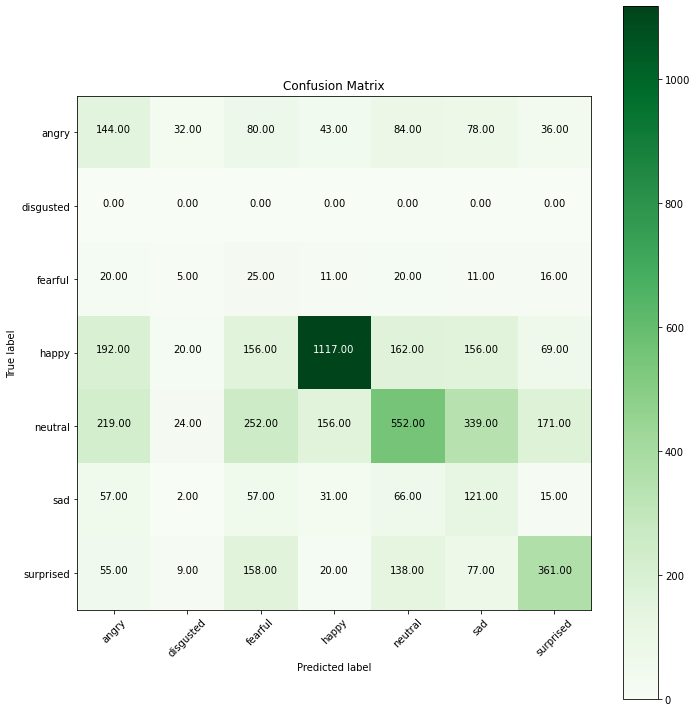

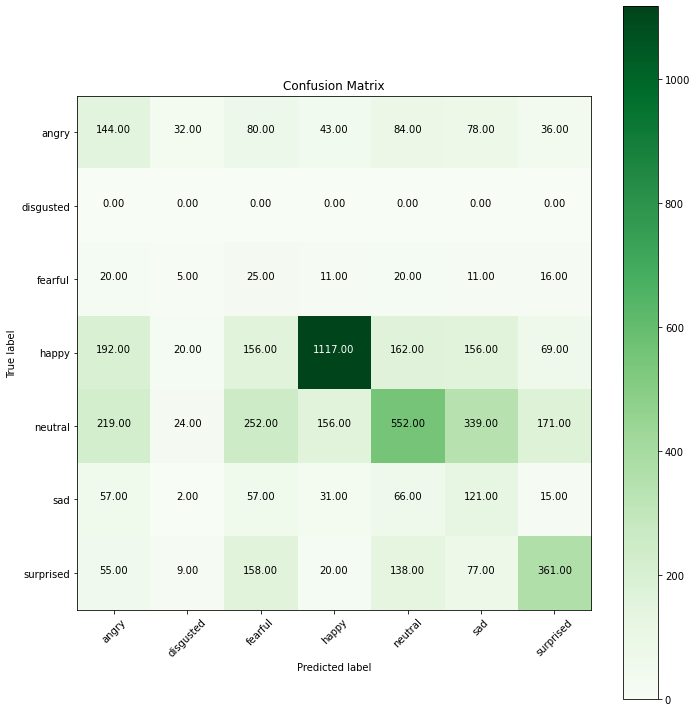

In [6]:
# Confusion matrix
DefinedCNN.visualise_confusion_matrix(plt.cm.Greens)

In [7]:
# Occlusion sensitivity

# Printing our classes, these are one of the only hard coded variables within the network wrapper.
classes = DefinedNN.classes()
classes_dic = DefinedNN.classes_dictionary()
print(classes)
print(classes_dic)



['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


## Occlusion Sensitivity

In [8]:
# Sorted predictions are sorted into classes (angry, sad, disgust etc), where each class has an array of True(ly) and False(ly) predicted images.
# Kernel size is the size of how big the kernel is that slides over the image to cover up the parts.
# Factor is the scaling to make the heat map for the occlusion sensitivity more red or more blue.
# figsize is figure size.

# Example below, I target the angry faces, and I target the most CORRECT accurately predicted angry face.
img = sorted_pred[DefinedCNN.classes_dictionary['angry']].get(True)[0]
fig1, fig2 = DefinedCNN.visualise_occlusion_sensitivity(img, kernel=(8,8), figsize=(10,10), factor=300, fontsize=10*1.5,cmap=plt.cm.coolwarm)


# Example below, I target the angry faces, and I target the most INCORRECT not accurately predicted angry face (With highest softmax score but was incorrectly predicted).
img = sorted_pred[DefinedCNN.classes_dictionary['angry']].get(False)[0]
fig1, fig2 = DefinedCNN.visualise_occlusion_sensitivity(img, kernel=(8,8), figsize=(10,10), factor=300, fontsize=10*1.5,cmap=plt.cm.coolwarm)


IndexError: tuple index out of range